In [1]:
import pickle
import glob

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
from scipy.stats import entropy
def oent(outputs):
    out_entropy4 = []
    for o in outputs:
        A = o
        #for i in range(A.shape[0]):
        a = np.squeeze(A)
        n, c = np.histogram(a,16)
        p = n/sum(n)
        e = entropy(p)
        out_entropy4.append(e)
    return np.asarray(out_entropy4)

In [5]:
test_batch = unpickle('cifar/data_test/cifar-10-batches-py/test_batch')

In [6]:
import cv2
import os

!mkdir data_test/batch_test

In [7]:
test_batch[b'size'] = []
for i,f in enumerate(test_batch[b'filenames']):
    f = f.decode('utf-8')
    d = test_batch[b'data'][i]
    #im = np.transpose(d.reshape(3,32,32),(1,2,0))
    #cv2.imwrite('data_test/batch_test/'+f,cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
    test_batch[b'size'].append(os.path.getsize('cifar/data_test/batch_test/'+f))

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from cifar.models import *

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [11]:
testset = torchvision.datasets.CIFAR10(
    root='cifar//data_test', train=True, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=1)

In [12]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


In [13]:
net = ResNet18()

In [14]:
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [15]:
criterion = nn.CrossEntropyLoss()

In [38]:
def test():
    
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    out = []
    feat = []
    labs = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs,features = net(inputs)
            
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            out.extend(predicted.tolist())
            feat.extend(features.cpu().numpy())
            labs.extend(targets.cpu().numpy())
    # Save checkpoint.
    acc = 100.*correct/total
    print("XXX",acc)
    return out,acc,feat

In [35]:
checkpoint = torch.load('cifar/DefMLR005_50000_2472.777_274.211//checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'])
pred,o,labs = test()

XXX 100.0


In [36]:
len(pred)
labels = np.asarray(labs)

In [37]:
len(labels)

50000

In [21]:
labels = np.asarray(test_batch[b'labels'])
tsz = np.asarray(test_batch[b'size'])
test_size = tsz

In [39]:
labels.shape

(50000,)

In [40]:
files = glob.glob('cifar/DefMLR005_50000_2472.777_274.211//checkpoint/*_*.pth')
ind = {}
feat = {}
for f in files:
    name = f.split('/')[-1].split('_')[1].split('.')[0]
    checkpoint = torch.load(f)
    net.load_state_dict(checkpoint['net'])
    #print(name)
    pred,o,f = test()
    ind[name] = np.where(pred==labels)[0]
    feat[name] = f

XXX 99.364
XXX 100.0
XXX 97.904
XXX 99.998
XXX 97.432
XXX 100.0
XXX 92.83
XXX 90.21
XXX 100.0
XXX 95.038
XXX 51.184
XXX 100.0
XXX 91.714


In [41]:
_ind = {}
for k in ind.keys():
    _ind[int(k)] = ind[k]
keylist = np.sort(list(_ind.keys()))
I = {}
for i,k in enumerate(keylist):
    tmp = _ind[k]
    for l in keylist[i+1:]:
        tmp = np.intersect1d(tmp,_ind[l])
    #print(i,k,tmp.shape)
    if i==0:
        I[k] = tmp
    else:
        for l in keylist[:i]:
            #print(tmp.shape,I[l].shape)
            tmp = np.setdiff1d(tmp,I[l])
            #print(tmp.shape)
        I[k] = tmp

In [43]:
np.setdiff1d(_ind[20],_ind[0]).shape

(20864,)

In [44]:
a = []
s = 0
v = []
for k in I.keys():
    print(I[k].shape,np.mean(tsz[I[k]]))
    #plt.plot(szf[I[k]],'.')
    a.append(np.mean(tsz[I[k]]))
    v.append(np.std(tsz[I[k]])/10)
    s+=I[k].shape[0]
plt.errorbar(x=np.arange(len(a)),y=a,yerr=v)
print(s)

IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [24]:
I[0]

array([    0,     1,     2, ..., 49991, 49992, 49998])

In [45]:
ff = np.zeros(50000)
for k in I.keys():
    for l in I[k]:
        ff[l] = int(k)
    

In [63]:
out_ent = {}
oe = []
for k in feat.keys():
    out_ent[int(k)] = oent(feat[k])

In [116]:
oe = []
for k in np.sort(list(out_ent.keys())):
    print(k,np.count_nonzero(ff==k))
    oe.append(out_ent[int(k)])

0 22293
20 16634
40 1898
60 2492
80 2311
100 1925
120 872
140 1256
160 318
180 1
200 0
220 0
240 0


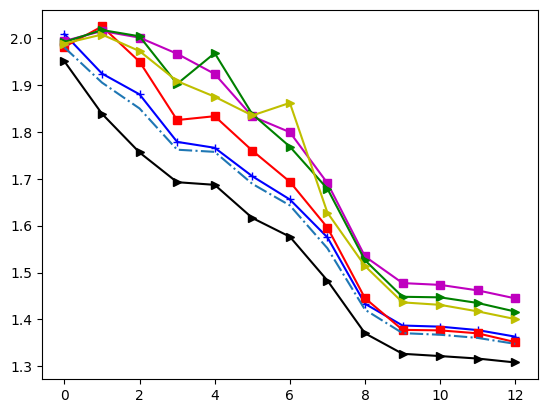

In [120]:
oe = np.asarray(oe)
doe = np.diff(oe,axis=0)
plt.plot(np.mean(oe[:,ff==20],1),'b-+')
plt.plot(np.mean(oe[:,ff==40],1),'r-s')
plt.plot(np.mean(oe[:,ff==80],1),'m-s')

plt.plot(np.mean(oe[:,ff==100],1),'g->')
plt.plot(np.mean(oe[:,ff==140],1),'y->')

plt.plot(np.mean(oe[:,ff==0],1),'k->')
plt.plot(np.mean(oe,1),'-.')
#plt.plot(doe[:,ff==40][:,0:10],'-s')
#plt.plot(doe[:,ff==100][:,0:10],'-<')

In [47]:
a = np.load('/mnt/efs/Work/understanding-curricula/orders/cifar10-cscores-orig-order.npz')['scores']

In [46]:
len(ff)

50000

In [48]:
from scipy.stats import spearmanr
spearmanr(ff,a)

SpearmanrResult(correlation=-0.6443872895317461, pvalue=0.0)

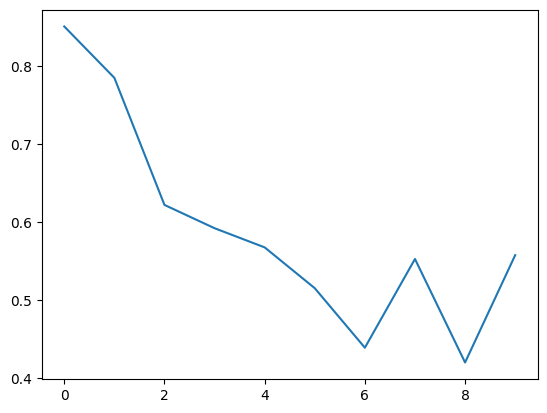

In [54]:
_tmp=[]
for u in  np.unique(ff):
    _tmp.append(np.mean(a[ff==u]))
plt.plot(_tmp)

In [19]:
import os

In [22]:
import glob
dirs = glob.glob('cifar/iterAugMix/*/')
#dics = {}
for d in dirs:
    name = d.split('/')[2]
    if 'Ran' in name or 'Lo' in name or 'Hi' in name or 'HiPr' in name or 'LoPr' in name or 'Bal' in name:
        checkpoint = torch.load(d+'/checkpoint/ckpt.pth')
        if not os.path.exists(d+'/checkpoint/ckpt_180.pth'):
            print("not done")
            continue
        net.load_state_dict(checkpoint['net'])
        print(name)
        pred,o,_ = test()
        dics[name] = o

Hi_25000_2646.066_143.621
XXX 82.55
Hi_5000_2794.658_88.534
XXX 56.06
Hi_15000_2706.978_117.956
XXX 75.15
Hi_35000_2589.738_172.330
XXX 87.0
not done
Lo_25000_2299.489_264.004
XXX 83.7
Lo_5000_1999.583_296.556
XXX 56.46
Lo_15000_2199.870_273.764
XXX 78.03


In [24]:
acc = []
ran = []
ran_n = []
lo = []
lo_n = []
hi = []
hi_n = []
bal = []
bal_n = []
hipr = []
hipr_n = []
lopr = []
lopr_n = []
for l in dics.keys():
        print(l)
        if 'Ran_' in l:
            ran.append(dics[l])
            ran_n.append(int(l.split('_')[1]))
        if 'Hi_' in l:
            hi.append(dics[l])
            hi_n.append(int(l.split('_')[1]))
        if 'Lo_' in l:
            lo.append(dics[l])
            lo_n.append(int(l.split('_')[1]))
        if 'Bal_' in l:
            bal.append(dics[l])
            bal_n.append(int(l.split('_')[1]))
        if 'HiPr' in l:
            hipr.append(dics[l])
            hipr_n.append(int(l.split('_')[1]))
        if 'LoPr' in l:
            lopr.append(dics[l])
            lopr_n.append(int(l.split('_')[1]))


Ran_25000_2471.975_276.094
Ran_5000_2474.632_275.081
Ran_15000_2474.105_273.765
Hi_25000_2646.066_143.621
Hi_5000_2794.658_88.534
Hi_15000_2706.978_117.956
Hi_35000_2589.738_172.330
Lo_25000_2299.489_264.004
Lo_5000_1999.583_296.556
Lo_15000_2199.870_273.764


In [25]:
ran = np.asarray(ran)
ran_n = np.asarray(ran_n)
hi = np.asarray(hi)
hi_n = np.asarray(hi_n)
lo = np.asarray(lo)
lo_n = np.asarray(lo_n)
bal = np.asarray(bal)
bal_n = np.asarray(bal_n)


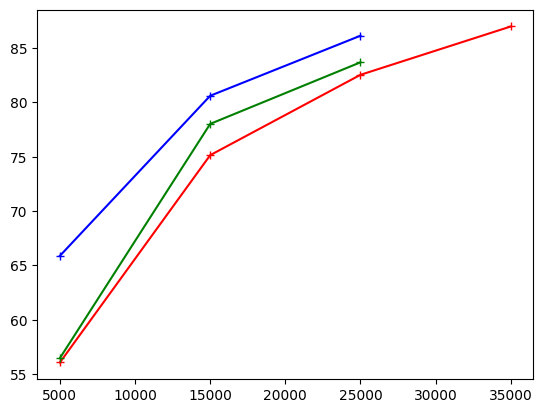

In [26]:
plt.plot(ran_n[np.argsort(ran_n)],ran[np.argsort(ran_n)],'b-+')
plt.plot(hi_n[np.argsort(hi_n)],hi[np.argsort(hi_n)],'r-+')
plt.plot(lo_n[np.argsort(lo_n)],lo[np.argsort(lo_n)],'g-+')
plt.plot(bal_n[np.argsort(bal_n)],bal[np.argsort(bal_n)],'k-+')

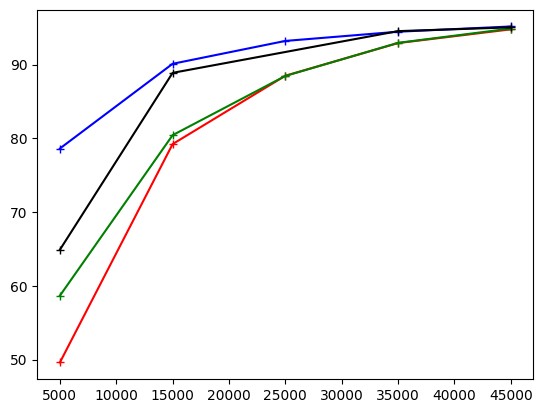

In [39]:
plt.plot(ran_n[np.argsort(ran_n)],ran[np.argsort(ran_n)],'b-+')
plt.plot(hi_n[np.argsort(hi_n)],hi[np.argsort(hi_n)],'r-+')
plt.plot(lo_n[np.argsort(lo_n)],lo[np.argsort(lo_n)],'g-+')
plt.plot(bal_n[np.argsort(bal_n)],bal[np.argsort(bal_n)],'k-+')

In [23]:
res_cfm = {}
res_acc_tsz = {}
res_acc_tsz_ = {}
res = {}

In [61]:
checkpoint = torch.load('B/checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'])
name = 'Ran5000'

In [62]:
labels = np.asarray(test_batch[b'labels'])

In [63]:
p = test()
res[name] = np.count_nonzero(p==labels)/len(labels)
pred = p

XXX 88.53


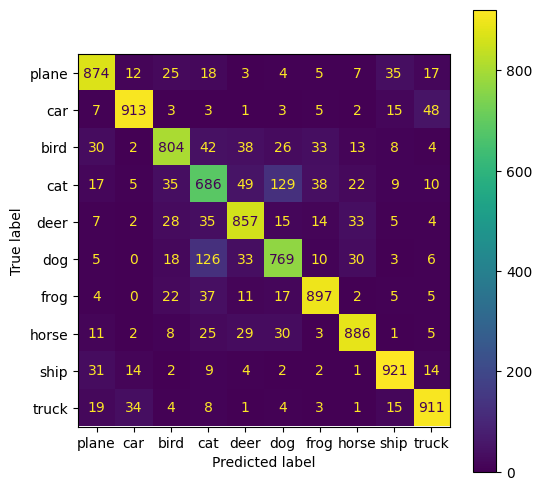

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels,pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
#cmd.plot()
fig, ax = plt.subplots(figsize=(6,6))
cmd.plot(ax=ax)

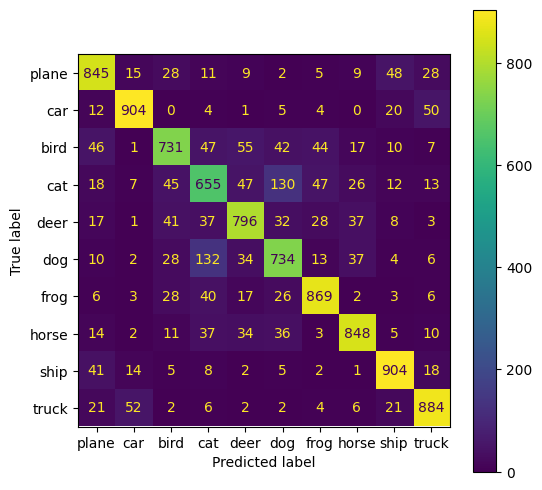

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels,pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
#cmd.plot()
fig, ax = plt.subplots(figsize=(6,6))
cmd.plot(ax=ax)

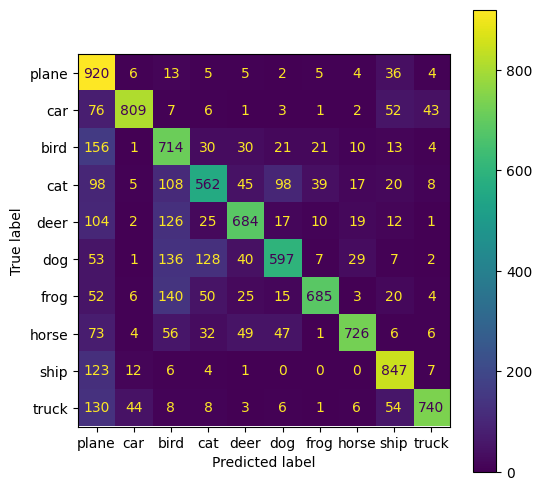

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels,pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
#cmd.plot()
fig, ax = plt.subplots(figsize=(6,6))
cmd.plot(ax=ax)

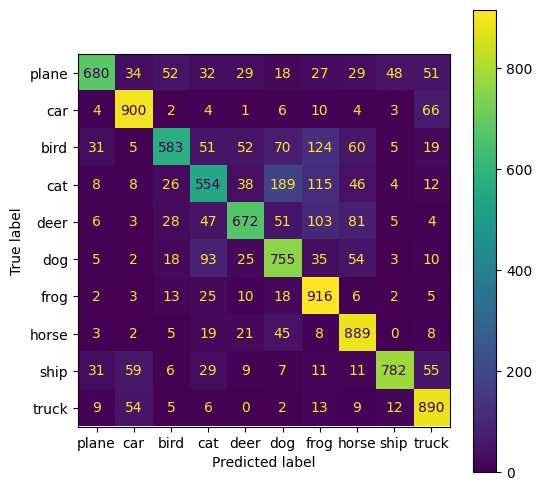

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels,pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
#cmd.plot()
fig, ax = plt.subplots(figsize=(6,6))
cmd.plot(ax=ax)

In [1]:
from styleaug import StyleAugmentor

import torch
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import matplotlib.pyplot as plt


# PyTorch Tensor <-> PIL Image transforms:
toTensor = ToTensor()
toPIL = ToPILImage()

In [47]:
im = Image.open('data/stl10_imgs/train_imgs/img_000051.jpg')
print(os.path.getsize('data/stl10_imgs/train_imgs/img_000051.jpg'))
im_torch = toTensor(im).unsqueeze(0) # 1 x 3 x 256 x 256
im_torch = im_torch.to('cuda:0' if torch.cuda.is_available() else 'cpu')

7924


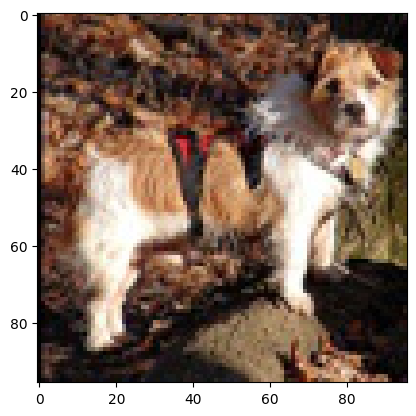

In [48]:
plt.imshow(im)

2446


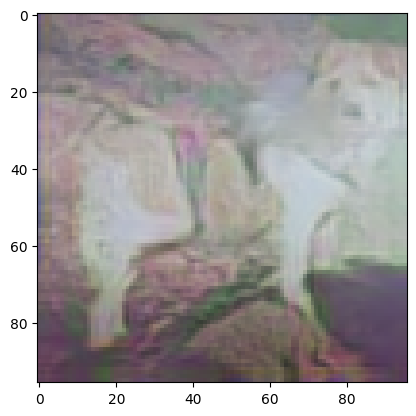

In [55]:
# create style augmentor:
augmentor = StyleAugmentor()

# randomize style:
im_restyled = augmentor(im_torch)
plt.imsave('test.jpg',toPIL(im_restyled.squeeze().cpu()))
print(os.path.getsize('test.jpg'))
# display:
plt.imshow(toPIL(im_restyled.squeeze().cpu()))
plt.show()


In [18]:
pred_labels = np.asarray(pred)

In [18]:
out_entropy = oent(feat)

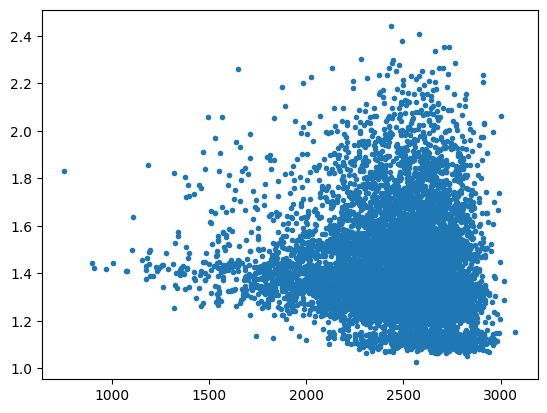

In [21]:
plt.plot(tsz,out_entropy,'.')

from scipy.spatial.distance import pdist,squareform

D = pdist(feat,'euclidean')

D = squareform(D)

D = D+np.max(D)*2*np.eye(D.shape[0])

labels[np.argmin(D,1)]

np.where(labels!=labels[np.argmin(D,1)])[0].shape[0]/len(labels)

knn_labels = labels[np.argmin(D,1)]

np.where(labels!=pred_labels)[0].shape[0]/len(labels)

size = np.asarray(test_batch[b'size'])

np.mean(size[np.where(labels!=pred_labels)])

np.mean(size[np.where(labels==pred_labels)])

np.mean(size[np.where(labels!=knn_labels)])

np.mean(size[np.where(labels==knn_labels)])

ind = np.where(pred_labels!=labels)[0]


k = ind[np.random.choice(len(ind))]

plt.imshow(plt.imread('data_test/batch_test/'+test_batch[b'filenames'][k].decode('utf-8')))
print(test_batch[b'filenames'][k], os.path.getsize('data_test/batch_test/'+test_batch[b'filenames'][k].decode('utf-8')))

np.unique(labels[ind],return_counts=True)

In [24]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
res_cfm[name] = confusion_matrix(labels,pred_labels)

In [22]:
tsz = np.asarray(test_batch[b'size'])
test_size = tsz

In [23]:
files = glob.glob('cifar/DefMLR005_50000_2472.777_274.211//checkpoint/*_*.pth')
out_ent = {}
acc = {}
for f in files:
    name = f.split('/')[-1].split('_')[1].split('.')[0]
    checkpoint = torch.load(f)
    net.load_state_dict(checkpoint['net'])
    #print(name)
    pred,o,feat = test()
    out_ent[int(name)] =  oent(feat)
    acc[int(name)]  =o 

XXX 93.22
XXX 95.41
XXX 92.56
XXX 94.96
XXX 90.81
XXX 95.12
XXX 87.84
XXX 86.55
XXX 95.53
XXX 89.97
XXX 50.74
XXX 95.52
XXX 87.25


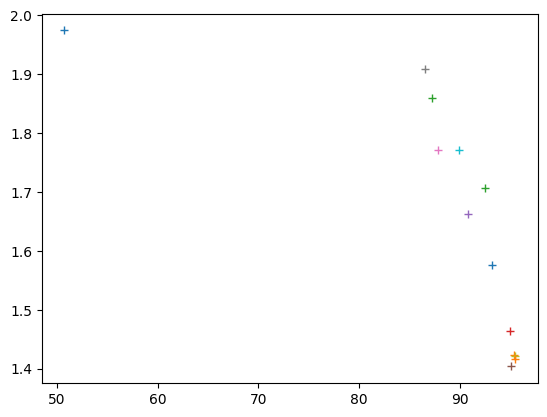

In [24]:
for k in out_ent.keys():
    plt.plot(acc[k],np.mean(out_ent[k]),'-+')

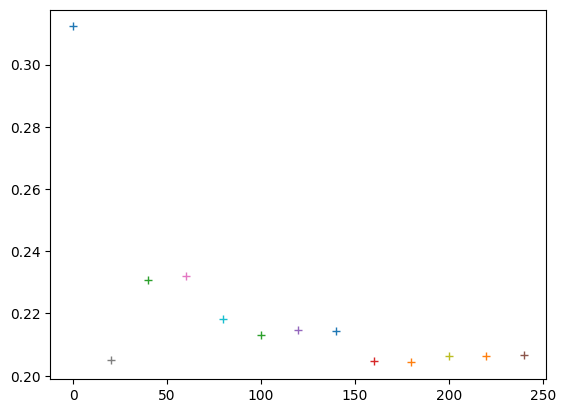

In [29]:
for k in out_ent.keys():
    plt.plot(int(k),np.std(out_ent[k]),'-+')

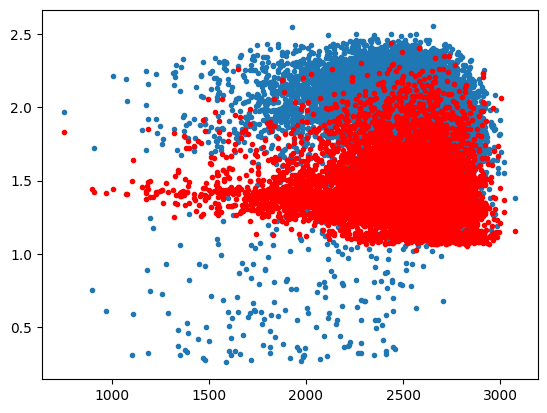

In [29]:
plt.plot(test_size,out_entropy0,'.')
#plt.plot(test_size,out_entropy40,'.')
#plt.plot(test_size,out_entropy80,'.')
#plt.plot(test_size,out_entropy120,'.')
plt.plot(test_size,out_entropyB,'r.')

2491.262443438914 1.686866729740223
2472.7939 1.3938752623409414


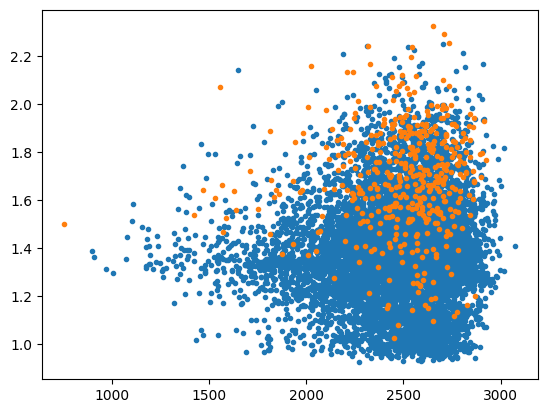

In [36]:
plt.plot(test_size[pred_labels==labels],out_entropyB[pred_labels==labels],'.')
plt.plot(test_size[pred_labels!=labels],out_entropyB[pred_labels!=labels],'.')
print(np.mean(test_size[pred_labels!=labels]),np.mean(out_entropyB[pred_labels!=labels]))
print(np.mean(test_size),np.mean(out_entropyB))

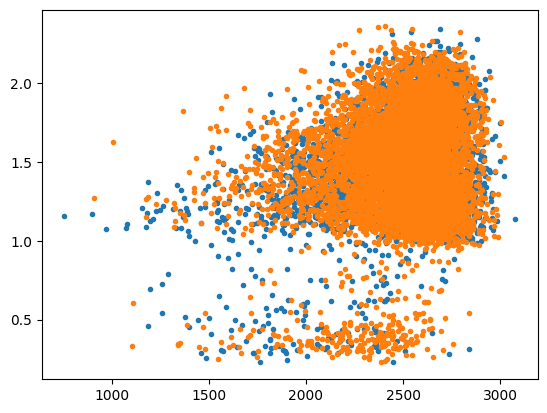

In [103]:
plt.plot(test_size[pred_labels==labels],out_entropy[pred_labels==labels],'.')
plt.plot(test_size[pred_labels!=labels],out_entropy[pred_labels!=labels],'.')

(array([ 721., 1131., 2333., 2778., 1596.,  811.,  416.,  157.,   44.,
          13.]),
 array([0.92401455, 1.06392   , 1.20382544, 1.34373088, 1.48363633,
        1.62354177, 1.76344722, 1.90335266, 2.04325811, 2.18316355,
        2.323069  ]),
 <BarContainer object of 10 artists>)

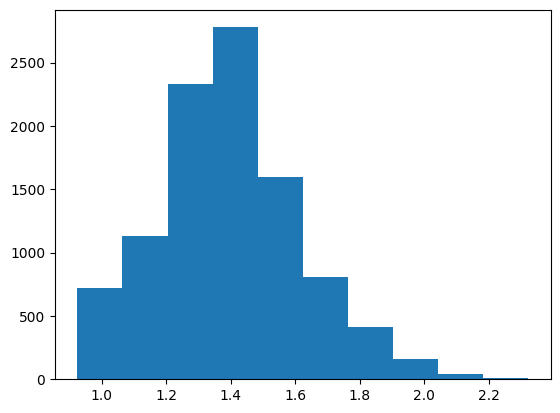

In [30]:
plt.hist(out_entropyB)

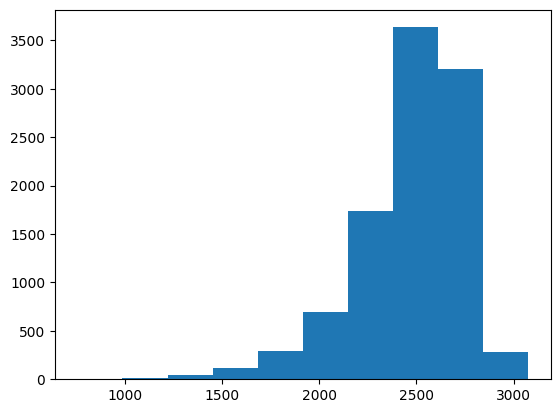

In [43]:
n,c,_ =plt.hist(tsz)
acc = []
#ind = np.where(tsz<=c[0])[0]
#acc.append(np.count_nonzero(labels[ind]==pred_labels[ind]))
for i in range(1,len(c)):
    ind = np.where(np.logical_and(tsz>=c[i-1],tsz<c[i]))[0]
    acc.append(np.count_nonzero(labels[ind]==pred_labels[ind]))
acc
res_acc_tsz[name]=acc/n

In [31]:
print(np.mean(np.asarray(test_batch[b'size'])),np.std(np.asarray(test_batch[b'size'])))

2472.7939 276.04396972727005


In [32]:
print(np.mean(np.asarray(test_batch[b'size'])[np.where(np.asarray(test_batch[b'labels'])==np.asarray(p))]),
      np.std(np.asarray(test_batch[b'size'])[np.where(np.asarray(test_batch[b'labels'])==np.asarray(p))]))

2471.9398409709142 276.1589712503024


In [33]:
print(np.mean(np.asarray(test_batch[b'size'])[np.where(np.asarray(test_batch[b'labels'])!=np.asarray(p))]),
      np.std(np.asarray(test_batch[b'size'])[np.where(np.asarray(test_batch[b'labels'])!=np.asarray(p))]))
res_acc_tsz_[name] = [np.mean(np.asarray(test_size)[np.where(np.asarray(labels)==np.asarray(p))]),np.std(np.asarray(test_size)[np.where(np.asarray(labels)==np.asarray(p))]),np.mean(np.asarray(test_size)[np.where(np.asarray(labels)!=np.asarray(p))]),np.std(np.asarray(test_size)[np.where(np.asarray(labels)==np.asarray(p))])]

2491.262443438914 272.8922332028632


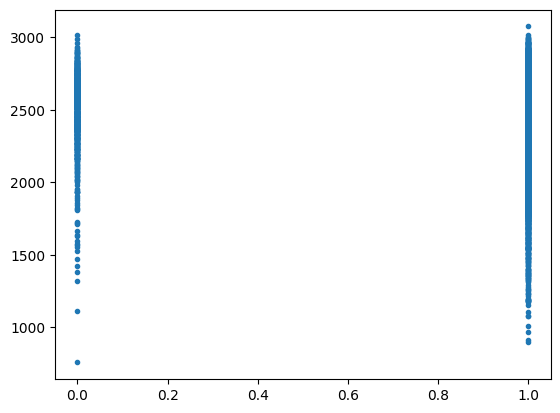

In [31]:
plt.plot(np.asarray(test_batch[b'labels'])==np.asarray(p),np.asarray(test_batch[b'size']),'.')


In [32]:
res

{'6ckpt': 0.9256}

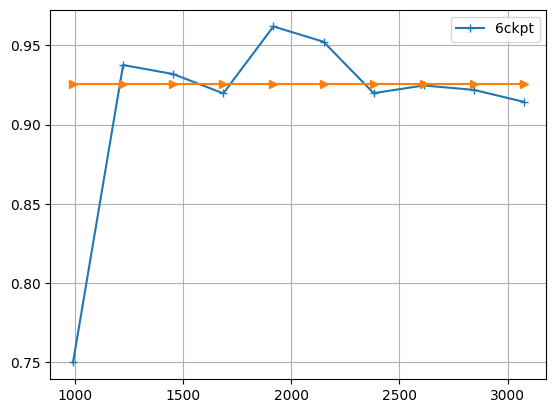

In [33]:
for k in res_acc_tsz.keys():
    plt.plot(c[1:],res_acc_tsz[k],'-+')
    
plt.legend(res.keys())
for k in res_acc_tsz.keys():
    plt.plot(c[1:],res[k]*np.ones(len(c)-1),'->')
plt.grid()

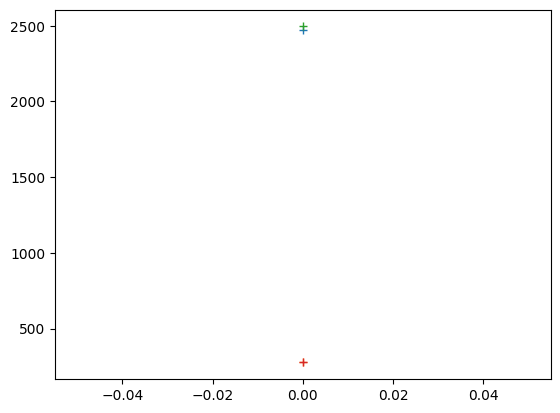

In [34]:
plt.plot(res_acc_tsz_.values(),'-+')

In [43]:
orig_prediction = p.copy()

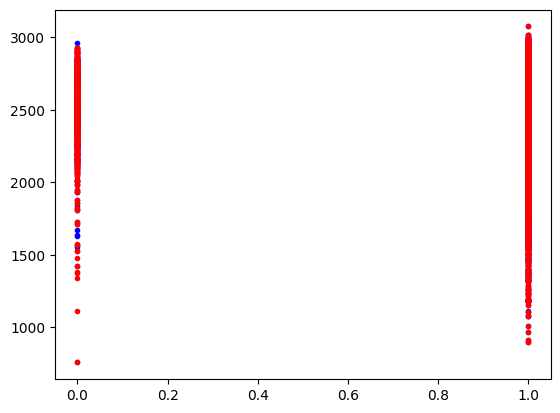

In [87]:
plt.plot(np.asarray(test_batch[b'labels'])==np.asarray(orig_prediction),np.asarray(test_batch[b'size']),'b.')
plt.plot(np.asarray(test_batch[b'labels'])==np.asarray(random_prediction),np.asarray(test_batch[b'size']),'r.')
#plt.plot(np.asarray(test_batch[b'labels'])==np.asarray(hi_prediction),np.asarray(test_batch[b'size']),'g.')
#plt.plot(np.asarray(test_batch[b'labels'])==np.asarray(lo_prediction),np.asarray(test_batch[b'size']),'k.')

In [96]:
orig_prediction = np.asarray(orig_prediction)
random_prediction = np.asarray(random_prediction)
hi_prediction = np.asarray(hi_prediction)
lo_prediction = np.asarray(lo_prediction)
size = np.asarray(test_batch[b'size'])
labels = np.asarray(test_batch[b'labels'])

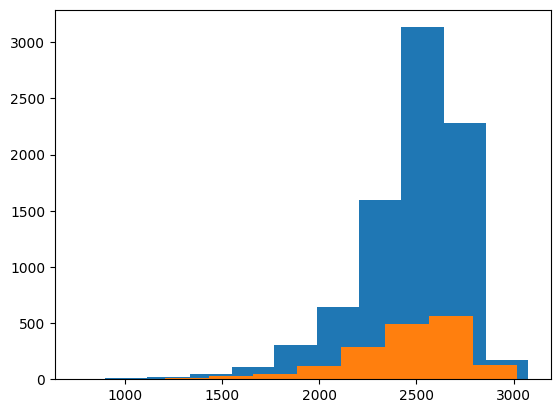

In [95]:
_=plt.hist(size[np.where(hi_prediction==lo_prediction)])
_=plt.hist(size[np.where(hi_prediction!=lo_prediction)])

# _=plt.hist(size[np.where(hi_prediction!=orig_prediction)])
# _=plt.hist(size[np.where(lo_prediction==orig_prediction)])
# _=plt.hist(size[np.where(lo_prediction!=orig_prediction)])

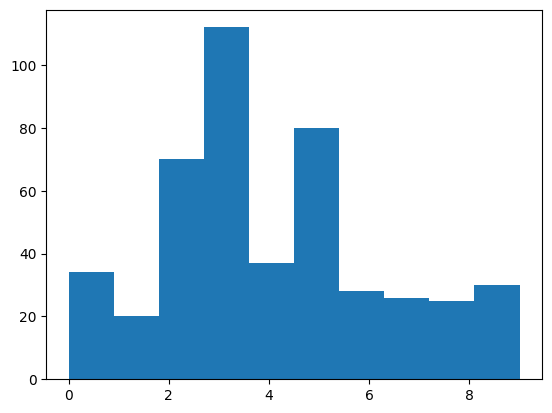

In [98]:
_=plt.hist(labels[np.where(orig_prediction!=labels)])

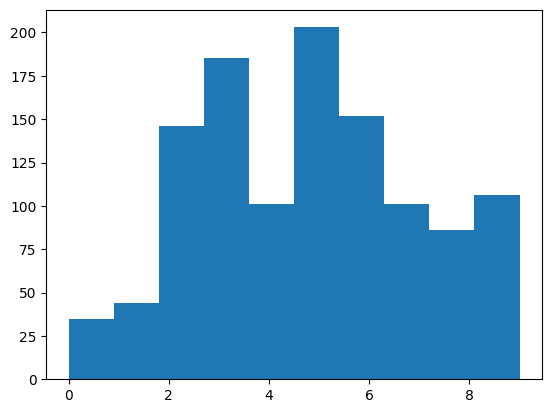

In [99]:
_=plt.hist(labels[np.where(hi_prediction!=labels)])

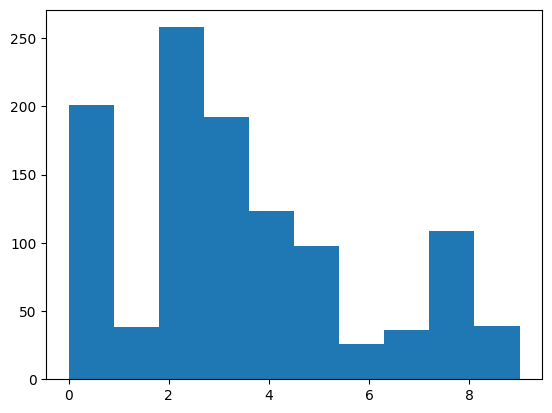

In [100]:
_=plt.hist(labels[np.where(lo_prediction!=labels)])

(array([  1.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   1.,   1.,
          0.,   0.,   2.,   0.,   2.,   0.,   1.,   8.,   2.,   3.,   4.,
          1.,   1.,   6.,   8.,   7.,   7.,   4.,   3.,   7.,   8.,   7.,
         13.,  14.,  15.,   9.,  15.,  13.,  11.,  15.,  19.,  20.,  23.,
         34.,  28.,  33.,  32.,  42.,  42.,  56.,  47.,  63.,  48.,  66.,
         66.,  62.,  88.,  93., 101., 115., 124., 133., 127., 174., 188.,
        177., 209., 223., 263., 255., 289., 319., 336., 374., 384., 381.,
        438., 435., 423., 450., 441., 403., 376., 399., 299., 274., 250.,
        168., 139., 101.,  53.,  62.,  29.,  14.,  12.,   6.,   2.,   0.,
          1.]),
 array([ 757.  ,  780.19,  803.38,  826.57,  849.76,  872.95,  896.14,
         919.33,  942.52,  965.71,  988.9 , 1012.09, 1035.28, 1058.47,
        1081.66, 1104.85, 1128.04, 1151.23, 1174.42, 1197.61, 1220.8 ,
        1243.99, 1267.18, 1290.37, 1313.56, 1336.75, 1359.94, 1383.13,
        1406.32, 1429.51, 1452.7 ,

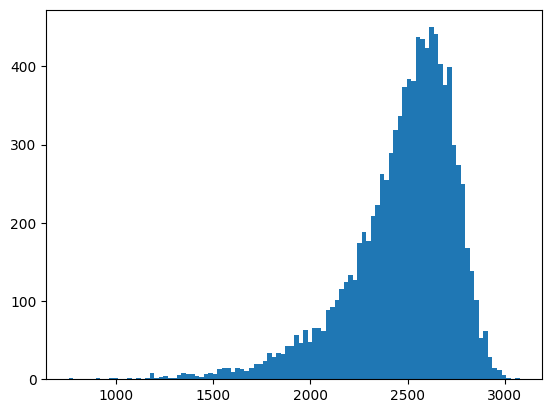

In [82]:
plt.hist(test_batch[b'size'],100)

In [1]:
from torchvision import models
import torch.nn as nn
# load pretrain model and modify...
model = models.resnet18(pretrained=False)
#model = Simple(2)
# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.

# for param in model.parameters():
#     param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.to("cuda")

/home/ubuntu/anaconda3/envs/latest_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/latest_pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
checkpoint = torch.load('../checpoint_epoch_0.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [3]:
import torch

In [6]:
checkpoint.keys()

dict_keys(['model_state_dict', 'optimizer_state_dict'])

In [9]:
import scipy.io

In [37]:
A = scipy.io.loadmat('../pytorch-cifar_new/x.mat')['d']

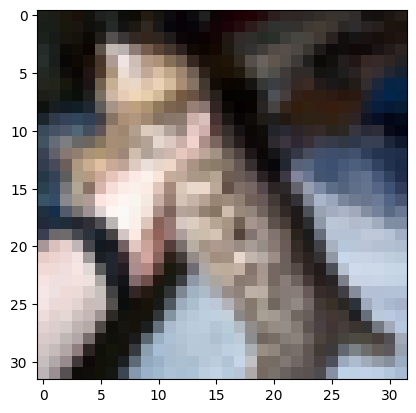

In [38]:
plt.imshow(A[1200])

In [21]:
!mkdir X

In [39]:
import cv2

In [40]:
sz = []
for i in range(A.shape[0]):
    cv2.imwrite('X/'+str(i)+'_.png',cv2.cvtColor(A[i],cv2.COLOR_RGB2BGR))
    sz.append(os.path.getsize('X/'+str(i)+'_.png'))

In [25]:
import os

(array([   6.,   18.,   22.,   60.,  144.,  377.,  831., 1734., 1579.,
         229.]),
 array([ 856. , 1073.4, 1290.8, 1508.2, 1725.6, 1943. , 2160.4, 2377.8,
        2595.2, 2812.6, 3030. ]),
 <BarContainer object of 10 artists>)

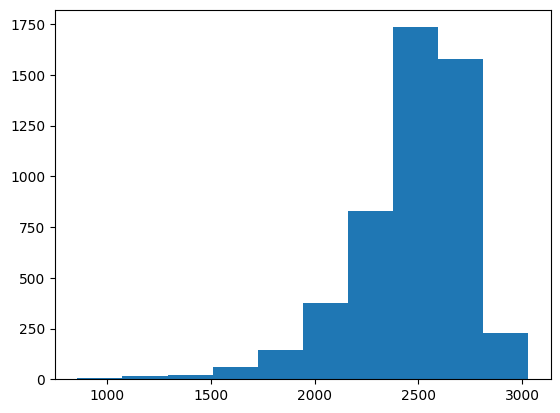

In [27]:
plt.hist(sz)

In [28]:
np.sum(sz)

12330025

In [33]:
np.sum(sz)

9997914

(array([1.000e+00, 3.000e+00, 1.900e+01, 8.100e+01, 1.440e+02, 3.070e+02,
        5.550e+02, 8.130e+02, 1.118e+03, 1.959e+03]),
 array([ 461. ,  650.9,  840.8, 1030.7, 1220.6, 1410.5, 1600.4, 1790.3,
        1980.2, 2170.1, 2360. ]),
 <BarContainer object of 10 artists>)

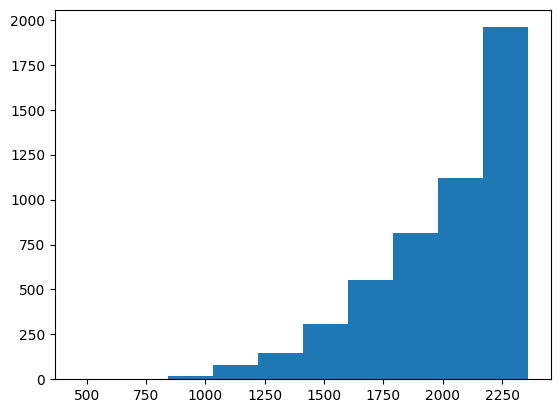

In [34]:
plt.hist(sz)

In [41]:
np.sum(sz)

13973292

(array([ 224.,  308.,  226.,  586., 1559., 1304.,  554.,  188.,   44.,
           7.]),
 array([2551. , 2604.4, 2657.8, 2711.2, 2764.6, 2818. , 2871.4, 2924.8,
        2978.2, 3031.6, 3085. ]),
 <BarContainer object of 10 artists>)

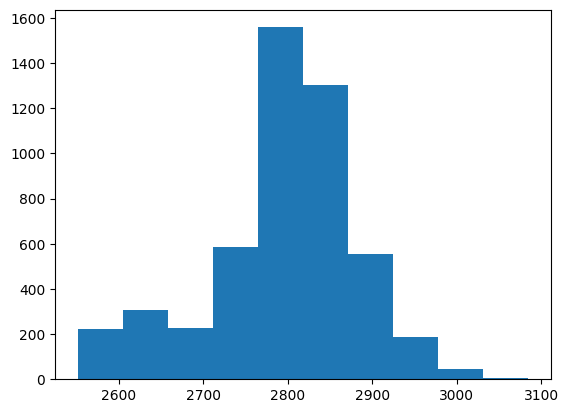

In [42]:
plt.hist(sz)

In [48]:
B = scipy.io.loadmat('../pytorch-cifar_new/x.mat')['t']

In [49]:
np.unique(B,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050]))

In [1]:
import torchvision

In [2]:
torchvision.datasets.Kitti('../data/',download=True)

Dataset Kitti
    Number of datapoints: 7481
    Root location: ../data/

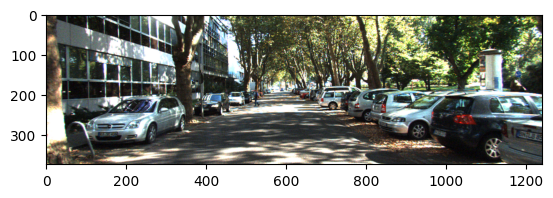

In [14]:
plt.imshow(plt.imread('../data/Kitti/raw/testing/image_2/006569.png'))